In [21]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [22]:
LEVERAGE = 10
INITIAL_CAP = 200000

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [23]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [24]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [25]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df.head()

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055,0.0008,3.174603e-08
1,2014-01-03,30.035,0.0008,3.174603e-08
2,2014-01-06,30.160,0.0008,3.174603e-08
3,2014-01-07,30.260,0.0007,2.777778e-08
4,2014-01-08,30.150,0.0007,2.777778e-08


In [26]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * LEVERAGE
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                         0.0009
Daily_EFFR                                      0.0
Daily_return                               0.005885
Daily_excess_return                        0.005885
Daily_excess_leverage_return               0.058849
Name: 196, dtype: object

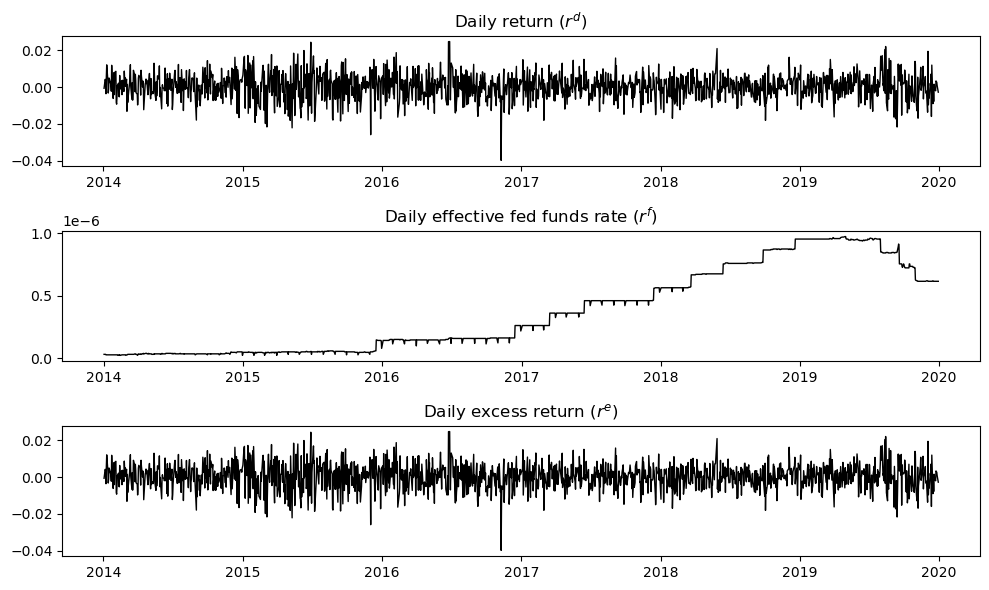

In [27]:
fig, ax = plt.subplots(3, 1, figsize = (10, 6))

ax[0].plot(df['Date'], df['Daily_return'], color = 'black', lw = 1)
ax[0].set_title(r'Daily return ($r^d$)')
ax[1].plot(df['Date'], df['Daily_EFFR'], color = 'black', lw = 1)
ax[1].set_title(r'Daily effective fed funds rate ($r^f$)')
ax[2].plot(df['Date'], df['Daily_excess_return'], color = 'black', lw = 1)
ax[2].set_title(r'Daily excess return ($r^e$)')
plt.tight_layout()

## 2. Trading Strategies

## Trend following strategy

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_21992/2557935867.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


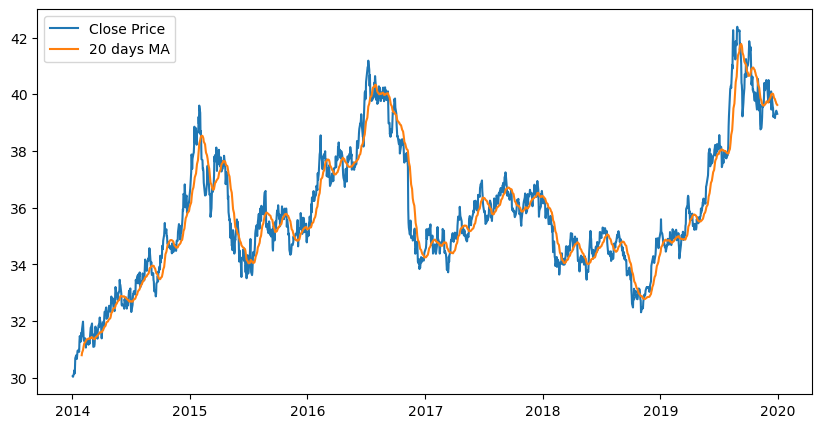

In [28]:
MA = 20
df['MA'] = df['Close'].rolling(MA).mean()
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(df['Date'], df['Close'], label = 'Close Price')
ax.plot(df['Date'], df['MA'], label = f'{MA} days MA')
plt.legend()
fig.show()


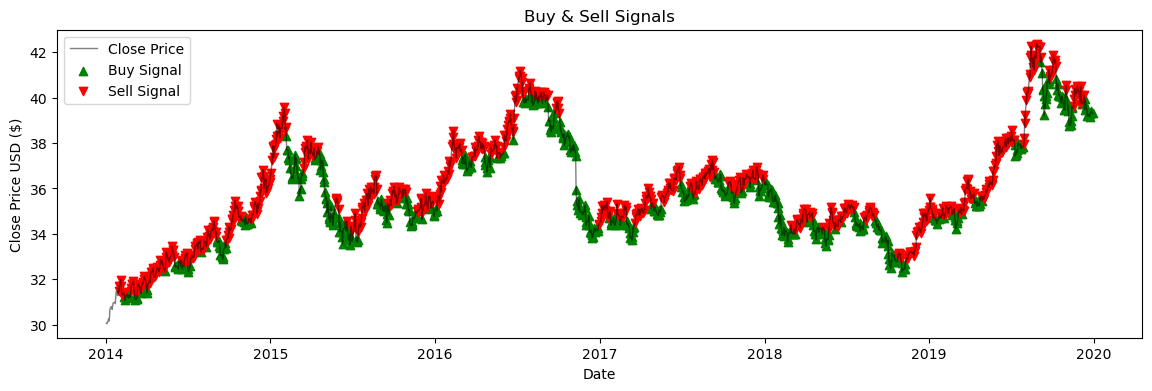

In [29]:
# Trend following strategy
train_set = df.copy()

# Explicitly create a copy of the DataFrame to avoid SettingWithCopyWarning
train_set = train_set.copy()

# If the current price is greater than the moving average, buy the asset
train_set.loc[:, 'Position'] = np.where(train_set['Close'] > train_set['MA'], -1, 0)
train_set.loc[:, 'Position'] = np.where(train_set['Close'] < train_set['MA'], 1, train_set['Position'])
train_set.loc[:, 'Position'] = train_set['Position'].ffill()

plot_signals(train_set, np.array(train_set['Position']))


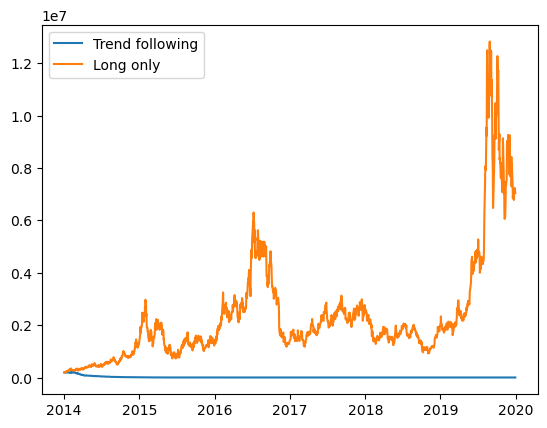

In [30]:
trend_following = compute_position_value(df = train_set, 
                                         signal = np.array(train_set['Position'].fillna(0)), 
                                         initial_capital = INITIAL_CAP, 
                                         max_leverage = LEVERAGE,
                                         hold_at_signal_0 = True) 
long_only = compute_position_value(df = train_set, 
                                      signal = np.ones(len(train_set)), 
                                      initial_capital = INITIAL_CAP, 
                                      max_leverage = LEVERAGE) 

plt.plot(train_set['Date'], trend_following['Vtot'], label = 'Trend following')
plt.plot(train_set['Date'], long_only['Vtot'], label = 'Long only')
plt.legend()
plt.show()

Turnover in dollar: 40843832.5475555
Turnover in unit: 1284167.820487257


/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/code/plotting_computation.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


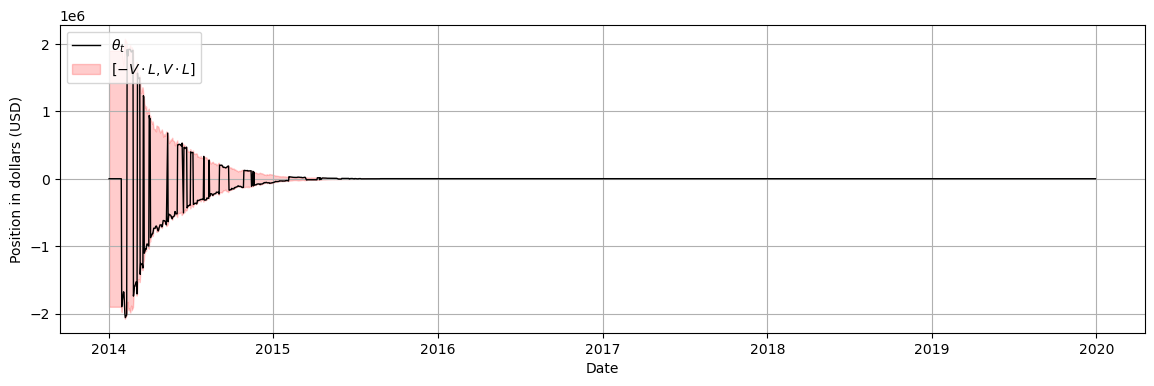

In [31]:
# Plot the position of strategy theta together with upper and lower bounds [-Vt * L, Vt * L]
plot_position(date = train_set['Date'], theta = trend_following['theta'], V = trend_following['V'], leverage = LEVERAGE)
turnover_dollar = calculate_turnover(theta = trend_following['theta'], price = train_set['Close'], mode = 'dollar')
turnover_unit = calculate_turnover(theta = trend_following['theta'], price = train_set['Close'], mode = 'unit')

print(f'Turnover in dollar: {turnover_dollar}\nTurnover in unit: {turnover_unit}')

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/code/plotting_computation.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


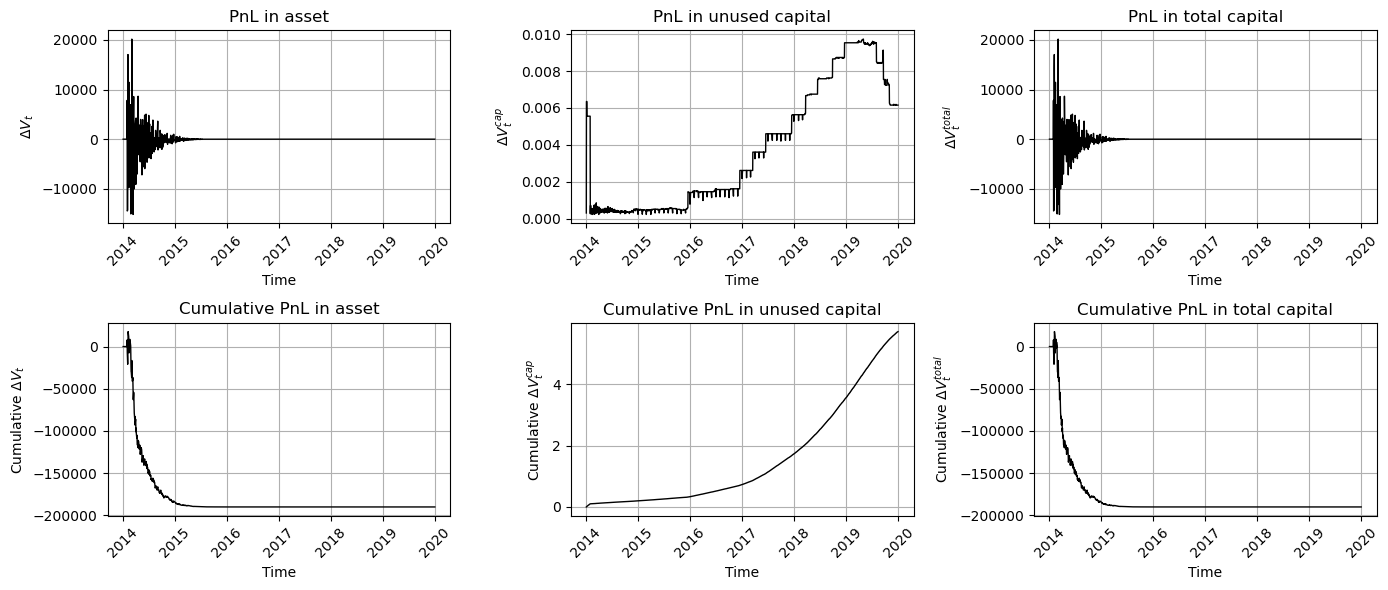

In [32]:
plot_PnL(date = train_set['Date'], dV = trend_following['dV'], dVcap = trend_following['dVcap'], dVtot = trend_following['dVtot'])

## Mean-reverting strategy

### 1. Simple mean-reverting strategy

[0.97463008 0.98132494 1.00259175 1.02154279 1.02874921]


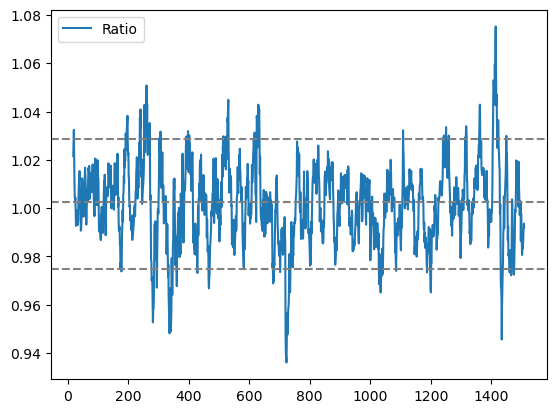

In [33]:
df['Ratio'] = df['Close'] / df['MA']
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['Ratio'].dropna(), percentiles)
print(p)
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['Ratio'].dropna(), percentiles)
df['Ratio'].dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--')

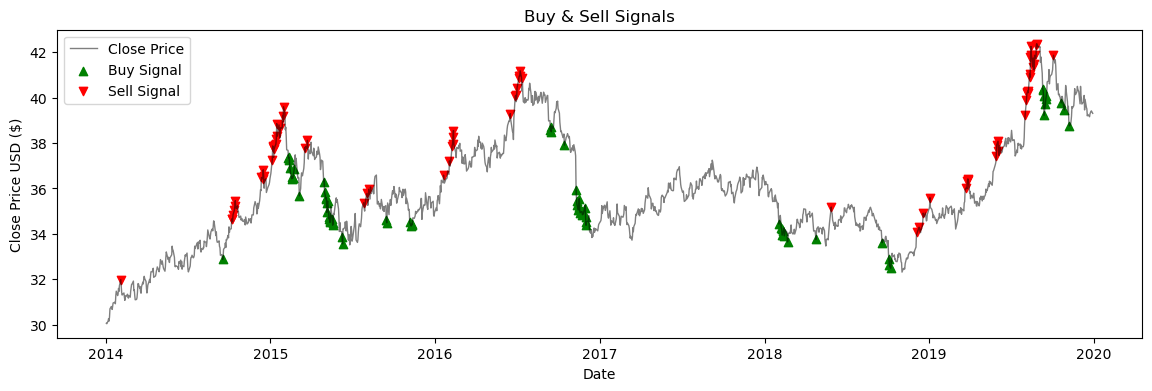

In [34]:
train_set = df
short = p[-1]
long = p[0]
train_set['Position'] = np.where(train_set['Ratio'] > short, -1, 0)
train_set['Position'] = np.where(train_set['Ratio'] < long, 1, train_set['Position'])
train_set['Position'] = train_set['Position'].ffill()
plot_signals(train_set, np.array(train_set['Position']))

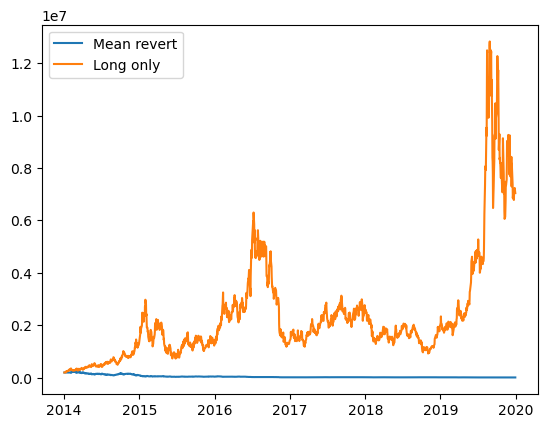

In [35]:
mean_revert = compute_position_value(df = train_set, 
                                     signal = np.array(train_set['Position'].fillna(0)), 
                                     initial_capital = INITIAL_CAP, 
                                     max_leverage = LEVERAGE,
                                     hold_at_signal_0 = True) 
long_only = compute_position_value(df = train_set, 
                                   signal = np.ones(len(train_set)), 
                                   initial_capital = INITIAL_CAP, 
                                   max_leverage = LEVERAGE) 

plt.plot(train_set['Date'], mean_revert['Vtot'], label = 'Mean revert')
plt.plot(train_set['Date'], long_only['Vtot'], label = 'Long only')
plt.legend()

### 2. Bollinger bands strategy

In [36]:
MA = 30
df['MA'] = df['Close'].rolling(MA).mean()
df['Ratio'] = df['Close'] / df['MA']
df['std'] = df['Close'].rolling(MA).std()
df['upper'] = df['MA'] + 2 * df['std']
df['lower'] = df['MA'] - 2 * df['std']
df['long_MA'] = df['Close'].rolling(50).mean()

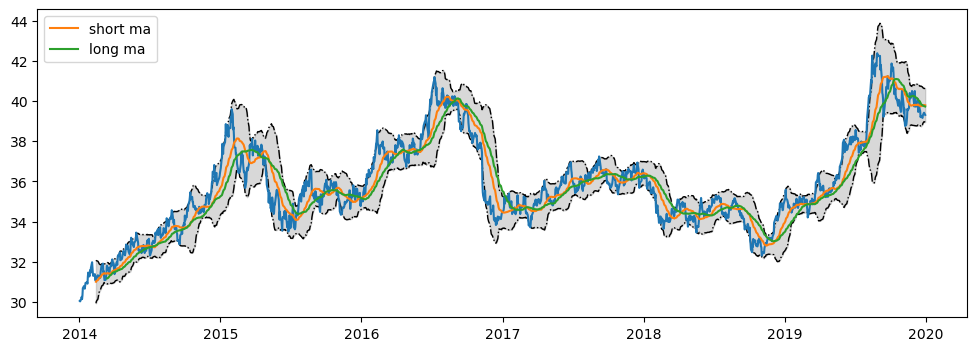

In [37]:
plt.figure(figsize = (12, 4))
plt.plot(df['Date'], df['upper'], color = 'black', lw = 1, ls = '-.')
plt.plot(df['Date'], df['lower'], color = 'black', lw = 1, ls = '-.')
plt.plot(df['Date'], df['Close'])
plt.plot(df['Date'], df['MA'], label = 'short ma')
plt.plot(df['Date'], df['long_MA'], label = 'long ma')
plt.fill_between(df['Date'], df['upper'], df['lower'], color = 'grey', alpha = 0.3)
plt.legend()

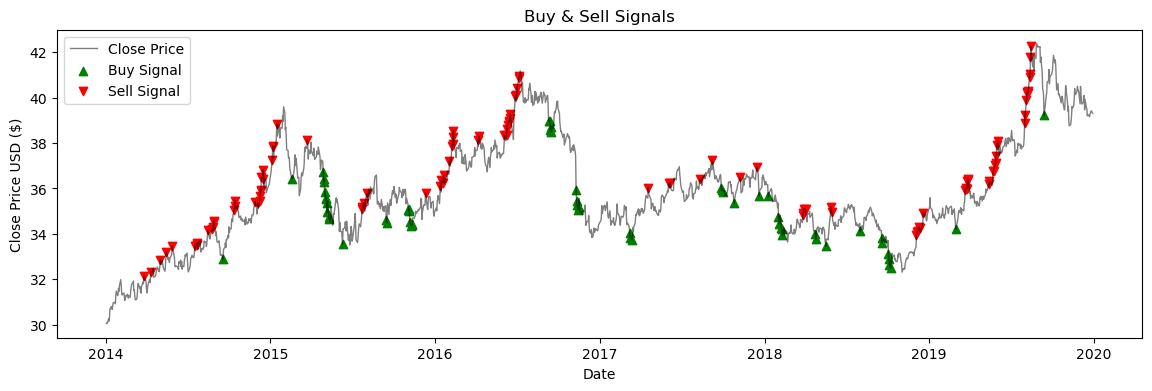

In [38]:
sell_signal = np.where(df['Close'] > df['upper'], -1, 0)
buy_signal = np.where(df['Close'] < df['lower'], 1, 0)
signal = sell_signal + buy_signal
plot_signals(df, np.array(signal))

## Auto-regressive model

/Users/chenkangan/tensorflow-test/env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


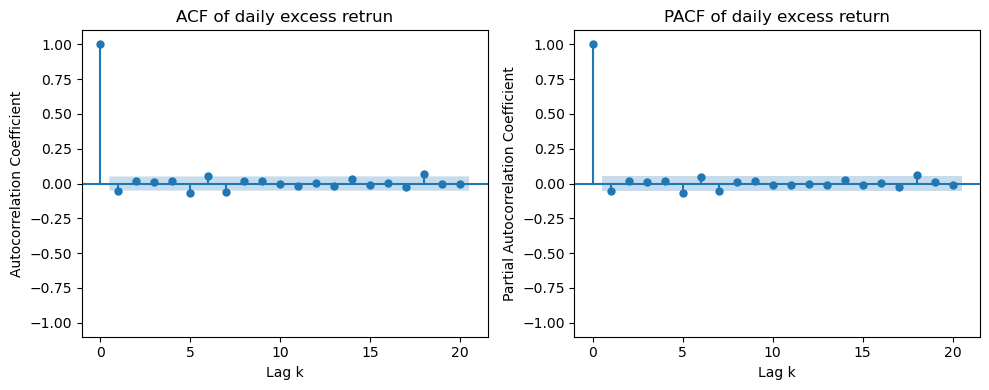

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Plot the ACF
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
LAG = 20
plot_acf(np.array(train_set['Daily_return'].dropna()), lags=LAG, ax=axs[0])  # You can adjust the number of lags as needed
axs[0].set_title(f'ACF of daily excess retrun')
axs[0].set_xlabel('Lag k')
axs[0].set_ylabel('Autocorrelation Coefficient')
axs[0].set_ylim(-1.1, 1.1)


plot_pacf(np.array(train_set['Daily_return'].dropna()), lags=LAG, ax=axs[1])  # You can adjust the number of lags as needed
axs[1].set_title(f'PACF of daily excess return')
axs[1].set_xlabel('Lag k')
axs[1].set_ylabel('Partial Autocorrelation Coefficient')
axs[1].set_ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()

## Buy and hold

/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/code/plotting_computation.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/chenkangan/Documents/UCL DSML/Algorithmic Trading/CW2/code/plotting_computation.py:163: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


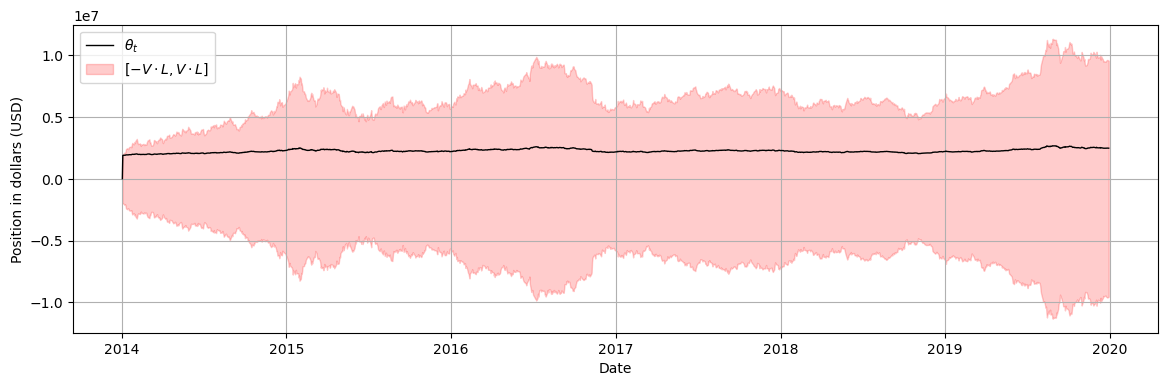

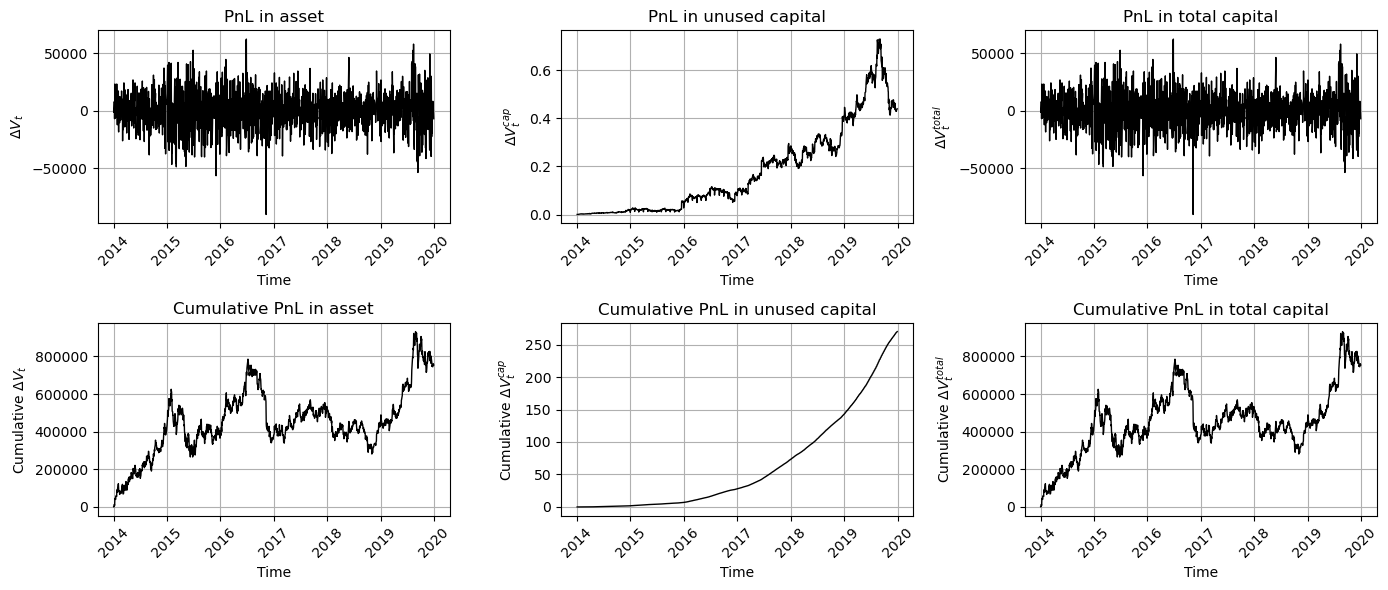

In [40]:
buy_and_hold_signal = np.zeros(len(df))
buy_and_hold_signal[1] = 1

result = compute_position_value(df = df, 
                           signal = buy_and_hold_signal, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)
plot_position(df['Date'], result['theta'], result['Vtot'], leverage=LEVERAGE) 
plot_PnL(df['Date'], result['dV'], result['dVcap'], result['dVtot'])